In [21]:
!pip install transformers
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  17.8M      0 --:--:-- --:--:-- --:--:-- 17.8M
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd
import transformers

In [23]:
bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased") 
bert_model.trainable = False
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = ["contradiction", "entailment", "neutral"]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [24]:
# There are more than 550k samples in total; we will use 100k for this example.
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=150000) # 20k
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")   # 10k
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")

Total train samples : 150000
Total validation samples: 10000
Total test samples: 10000


In [25]:
print(f"Sentence1: {train_df.loc[1, 'sentence1']}")
print(f"Sentence2: {train_df.loc[1, 'sentence2']}")
print(f"Similarity: {train_df.loc[1, 'similarity']}")

Sentence1: A person on a horse jumps over a broken down airplane.
Sentence2: A person is at a diner, ordering an omelette.
Similarity: contradiction


In [26]:
# We have some NaN entries in our train data, we will simply drop them.
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

Number of missing values
similarity    0
sentence1     0
sentence2     3
dtype: int64


In [27]:
print("Train Target Distribution")
print(train_df.similarity.value_counts())

Train Target Distribution
entailment       50053
contradiction    49951
neutral          49816
-                  177
Name: similarity, dtype: int64


In [28]:
print("Validation Target Distribution")
print(valid_df.similarity.value_counts())

Validation Target Distribution
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: similarity, dtype: int64


In [29]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

In [30]:
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

In [31]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence): 
    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )   

        bert_output = bert_model(**encoded)
        
        sequence_output = bert_output.last_hidden_state
#         pooled_output = bert_output.pooler_output
         
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return sequence_output, labels
        else:
            return sequence_output

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [32]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope(): 
    input_layer = tf.keras.layers.Input(shape=(128, 768), name=None)
#     input_layer=tf.reshape(input_layer, (128, 768), name=None) 
    
    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(input_layer) 
    
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)    
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=input_layer, outputs=output
    )
    
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 768)]   0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128, 128)     426496      input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 128)          0           bidirectional_1[0][0]            
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 128)          0           bidirectional_1[0][0]            
____________________________________________________________________________________________

In [33]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )

In [34]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

In [35]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2022-01-29 05:21:38.480634: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_14500201"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
       

Epoch 1/2
  28/4681 [..............................] - ETA: 13:59 - loss: 1.1261 - acc: 0.3850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  69/4681 [..............................] - ETA: 14:17 - loss: 1.0677 - acc: 0.4398

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  86/4681 [..............................] - ETA: 14:15 - loss: 1.0627 - acc: 0.4466

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 101/4681 [..............................] - ETA: 14:17 - loss: 1.0530 - acc: 0.4542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 108/4681 [..............................] - ETA: 14:15 - loss: 1.0467 - acc: 0.4586

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 114/4681 [..............................] - ETA: 14:14 - loss: 1.0436 - acc: 0.4627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 126/4681 [..............................] - ETA: 14:12 - loss: 1.0323 - acc: 0.4725

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 140/4681 [..............................] - ETA: 14:09 - loss: 1.0252 - acc: 0.4792

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 154/4681 [..............................] - ETA: 14:15 - loss: 1.0226 - acc: 0.4803

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 181/4681 [>.............................] - ETA: 14:09 - loss: 1.0081 - acc: 0.4952

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 187/4681 [>.............................] - ETA: 14:08 - loss: 1.0059 - acc: 0.4977

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 204/4681 [>.............................] - ETA: 14:04 - loss: 0.9945 - acc: 0.5072

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 207/4681 [>.............................] - ETA: 14:03 - loss: 0.9916 - acc: 0.5095

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 266/4681 [>.............................] - ETA: 13:54 - loss: 0.9578 - acc: 0.5338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 303/4681 [>.............................] - ETA: 13:47 - loss: 0.9372 - acc: 0.5490

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 340/4681 [=>............................] - ETA: 13:43 - loss: 0.9190 - acc: 0.5609

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 369/4681 [=>............................] - ETA: 13:37 - loss: 0.9066 - acc: 0.5700

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 396/4681 [=>............................] - ETA: 13:33 - loss: 0.8937 - acc: 0.5793

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 434/4681 [=>............................] - ETA: 13:24 - loss: 0.8808 - acc: 0.5881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 492/4681 [==>...........................] - ETA: 13:12 - loss: 0.8627 - acc: 0.5992

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 522/4681 [==>...........................] - ETA: 13:08 - loss: 0.8540 - acc: 0.6055

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 561/4681 [==>...........................] - ETA: 13:01 - loss: 0.8418 - acc: 0.6141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 589/4681 [==>...........................] - ETA: 12:55 - loss: 0.8339 - acc: 0.6182

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 607/4681 [==>...........................] - ETA: 12:51 - loss: 0.8286 - acc: 0.6216

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 720/4681 [===>..........................] - ETA: 12:30 - loss: 0.8020 - acc: 0.6387

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 783/4681 [====>.........................] - ETA: 12:18 - loss: 0.7913 - acc: 0.6458

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 790/4681 [====>.........................] - ETA: 12:17 - loss: 0.7891 - acc: 0.6470

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 794/4681 [====>.........................] - ETA: 12:16 - loss: 0.7882 - acc: 0.6474

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 826/4681 [====>.........................] - ETA: 12:10 - loss: 0.7825 - acc: 0.6514

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 833/4681 [====>.........................] - ETA: 12:08 - loss: 0.7810 - acc: 0.6520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 850/4681 [====>.........................] - ETA: 12:06 - loss: 0.7794 - acc: 0.6531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 870/4681 [====>.........................] - ETA: 12:02 - loss: 0.7768 - acc: 0.6545

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 878/4681 [====>.........................] - ETA: 12:00 - loss: 0.7755 - acc: 0.6553

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 883/4681 [====>.........................] - ETA: 11:59 - loss: 0.7747 - acc: 0.6558

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 913/4681 [====>.........................] - ETA: 11:54 - loss: 0.7701 - acc: 0.6586

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 920/4681 [====>.........................] - ETA: 11:52 - loss: 0.7694 - acc: 0.6594

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 977/4681 [=====>........................] - ETA: 11:41 - loss: 0.7632 - acc: 0.6638

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 983/4681 [=====>........................] - ETA: 11:40 - loss: 0.7628 - acc: 0.6639

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1023/4681 [=====>........................] - ETA: 11:33 - loss: 0.7572 - acc: 0.6670

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1029/4681 [=====>........................] - ETA: 11:32 - loss: 0.7566 - acc: 0.6674

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1054/4681 [=====>........................] - ETA: 11:27 - loss: 0.7538 - acc: 0.6689

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1157/4681 [======>.......................] - ETA: 11:07 - loss: 0.7427 - acc: 0.6758

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1170/4681 [======>.......................] - ETA: 11:04 - loss: 0.7417 - acc: 0.6763

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1205/4681 [======>.......................] - ETA: 10:58 - loss: 0.7384 - acc: 0.6784

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1209/4681 [======>.......................] - ETA: 10:58 - loss: 0.7381 - acc: 0.6786

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1262/4681 [=======>......................] - ETA: 10:47 - loss: 0.7343 - acc: 0.6807

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1266/4681 [=======>......................] - ETA: 10:47 - loss: 0.7337 - acc: 0.6810

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1293/4681 [=======>......................] - ETA: 10:41 - loss: 0.7323 - acc: 0.6818

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1332/4681 [=======>......................] - ETA: 10:34 - loss: 0.7291 - acc: 0.6839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1417/4681 [========>.....................] - ETA: 10:18 - loss: 0.7225 - acc: 0.6880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1430/4681 [========>.....................] - ETA: 10:15 - loss: 0.7214 - acc: 0.6886

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1432/4681 [========>.....................] - ETA: 10:15 - loss: 0.7213 - acc: 0.6886

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1434/4681 [========>.....................] - ETA: 10:14 - loss: 0.7211 - acc: 0.6888

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1447/4681 [========>.....................] - ETA: 10:12 - loss: 0.7200 - acc: 0.6893

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1559/4681 [========>.....................] - ETA: 9:51 - loss: 0.7128 - acc: 0.6938

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1567/4681 [=========>....................] - ETA: 9:49 - loss: 0.7121 - acc: 0.6942

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1599/4681 [=========>....................] - ETA: 9:43 - loss: 0.7102 - acc: 0.6953

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1605/4681 [=========>....................] - ETA: 9:42 - loss: 0.7098 - acc: 0.6955

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1647/4681 [=========>....................] - ETA: 9:34 - loss: 0.7078 - acc: 0.6968

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1652/4681 [=========>....................] - ETA: 9:33 - loss: 0.7074 - acc: 0.6969

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1696/4681 [=========>....................] - ETA: 9:25 - loss: 0.7051 - acc: 0.6981

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1703/4681 [=========>....................] - ETA: 9:23 - loss: 0.7049 - acc: 0.6982

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1709/4681 [=========>....................] - ETA: 9:22 - loss: 0.7048 - acc: 0.6982

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1774/4681 [==========>...................] - ETA: 9:10 - loss: 0.7009 - acc: 0.7005

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1913/4681 [===========>..................] - ETA: 8:44 - loss: 0.6936 - acc: 0.7048

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1945/4681 [===========>..................] - ETA: 8:38 - loss: 0.6924 - acc: 0.7054

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2014/4681 [===========>..................] - ETA: 8:25 - loss: 0.6891 - acc: 0.7071

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2062/4681 [============>.................] - ETA: 8:15 - loss: 0.6870 - acc: 0.7083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2075/4681 [============>.................] - ETA: 8:13 - loss: 0.6865 - acc: 0.7086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2091/4681 [============>.................] - ETA: 8:10 - loss: 0.6859 - acc: 0.7089

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2138/4681 [============>.................] - ETA: 8:01 - loss: 0.6843 - acc: 0.7096

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2176/4681 [============>.................] - ETA: 7:54 - loss: 0.6825 - acc: 0.7105

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2195/4681 [=============>................] - ETA: 7:50 - loss: 0.6814 - acc: 0.7110

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2208/4681 [=============>................] - ETA: 7:48 - loss: 0.6812 - acc: 0.7111

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2327/4681 [=============>................] - ETA: 7:25 - loss: 0.6772 - acc: 0.7133

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2337/4681 [=============>................] - ETA: 7:23 - loss: 0.6770 - acc: 0.7133

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2339/4681 [=============>................] - ETA: 7:23 - loss: 0.6768 - acc: 0.7134

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2356/4681 [==============>...............] - ETA: 7:20 - loss: 0.6762 - acc: 0.7138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2382/4681 [==============>...............] - ETA: 7:15 - loss: 0.6748 - acc: 0.7146

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2508/4681 [===============>..............] - ETA: 6:51 - loss: 0.6701 - acc: 0.7172

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2613/4681 [===============>..............] - ETA: 6:31 - loss: 0.6671 - acc: 0.7187

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2635/4681 [===============>..............] - ETA: 6:27 - loss: 0.6668 - acc: 0.7189

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2671/4681 [================>.............] - ETA: 6:20 - loss: 0.6659 - acc: 0.7195

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2678/4681 [================>.............] - ETA: 6:19 - loss: 0.6656 - acc: 0.7197

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2682/4681 [================>.............] - ETA: 6:18 - loss: 0.6655 - acc: 0.7197

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2711/4681 [================>.............] - ETA: 6:12 - loss: 0.6644 - acc: 0.7204

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2721/4681 [================>.............] - ETA: 6:10 - loss: 0.6639 - acc: 0.7206

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2748/4681 [================>.............] - ETA: 6:05 - loss: 0.6634 - acc: 0.7209

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2786/4681 [================>.............] - ETA: 5:58 - loss: 0.6624 - acc: 0.7214

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2797/4681 [================>.............] - ETA: 5:56 - loss: 0.6617 - acc: 0.7218

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2832/4681 [=================>............] - ETA: 5:49 - loss: 0.6609 - acc: 0.7222

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2845/4681 [=================>............] - ETA: 5:47 - loss: 0.6605 - acc: 0.7224

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2851/4681 [=================>............] - ETA: 5:46 - loss: 0.6603 - acc: 0.7226

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2855/4681 [=================>............] - ETA: 5:45 - loss: 0.6602 - acc: 0.7226

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2981/4681 [==================>...........] - ETA: 5:21 - loss: 0.6573 - acc: 0.7239

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3006/4681 [==================>...........] - ETA: 5:17 - loss: 0.6564 - acc: 0.7244

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3014/4681 [==================>...........] - ETA: 5:15 - loss: 0.6559 - acc: 0.7246

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3018/4681 [==================>...........] - ETA: 5:14 - loss: 0.6557 - acc: 0.7247

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3042/4681 [==================>...........] - ETA: 5:10 - loss: 0.6555 - acc: 0.7250

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3050/4681 [==================>...........] - ETA: 5:08 - loss: 0.6554 - acc: 0.7250

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3051/4681 [==================>...........] - ETA: 5:08 - loss: 0.6554 - acc: 0.7250

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3067/4681 [==================>...........] - ETA: 5:05 - loss: 0.6551 - acc: 0.7251

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3086/4681 [==================>...........] - ETA: 5:01 - loss: 0.6547 - acc: 0.7253

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3277/4681 [====================>.........] - ETA: 4:25 - loss: 0.6504 - acc: 0.7274

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3284/4681 [====================>.........] - ETA: 4:24 - loss: 0.6502 - acc: 0.7276

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3298/4681 [====================>.........] - ETA: 4:21 - loss: 0.6497 - acc: 0.7277

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3307/4681 [====================>.........] - ETA: 4:20 - loss: 0.6495 - acc: 0.7278

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3354/4681 [====================>.........] - ETA: 4:11 - loss: 0.6482 - acc: 0.7284

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3400/4681 [====================>.........] - ETA: 4:02 - loss: 0.6465 - acc: 0.7295

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3410/4681 [====================>.........] - ETA: 4:00 - loss: 0.6463 - acc: 0.7296

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3437/4681 [=====================>........] - ETA: 3:55 - loss: 0.6458 - acc: 0.7299

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3481/4681 [=====================>........] - ETA: 3:47 - loss: 0.6447 - acc: 0.7304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3515/4681 [=====================>........] - ETA: 3:40 - loss: 0.6440 - acc: 0.7307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3530/4681 [=====================>........] - ETA: 3:37 - loss: 0.6438 - acc: 0.7308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3533/4681 [=====================>........] - ETA: 3:37 - loss: 0.6437 - acc: 0.7308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3617/4681 [======================>.......] - ETA: 3:21 - loss: 0.6417 - acc: 0.7320

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3636/4681 [======================>.......] - ETA: 3:17 - loss: 0.6412 - acc: 0.7323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3672/4681 [======================>.......] - ETA: 3:11 - loss: 0.6411 - acc: 0.7324

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3688/4681 [======================>.......] - ETA: 3:08 - loss: 0.6408 - acc: 0.7326

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3698/4681 [======================>.......] - ETA: 3:06 - loss: 0.6407 - acc: 0.7325

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3762/4681 [=======================>......] - ETA: 2:54 - loss: 0.6389 - acc: 0.7335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3763/4681 [=======================>......] - ETA: 2:53 - loss: 0.6388 - acc: 0.7336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3782/4681 [=======================>......] - ETA: 2:50 - loss: 0.6383 - acc: 0.7338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3822/4681 [=======================>......] - ETA: 2:42 - loss: 0.6378 - acc: 0.7342

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3830/4681 [=======================>......] - ETA: 2:41 - loss: 0.6378 - acc: 0.7342

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3888/4681 [=======================>......] - ETA: 2:30 - loss: 0.6363 - acc: 0.7349

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3909/4681 [========================>.....] - ETA: 2:26 - loss: 0.6360 - acc: 0.7350

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3952/4681 [========================>.....] - ETA: 2:18 - loss: 0.6353 - acc: 0.7354

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3976/4681 [========================>.....] - ETA: 2:13 - loss: 0.6348 - acc: 0.7357

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3996/4681 [========================>.....] - ETA: 2:09 - loss: 0.6344 - acc: 0.7360

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4000/4681 [========================>.....] - ETA: 2:09 - loss: 0.6343 - acc: 0.7360

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4068/4681 [=========================>....] - ETA: 1:56 - loss: 0.6325 - acc: 0.7369

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4112/4681 [=========================>....] - ETA: 1:47 - loss: 0.6314 - acc: 0.7375

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4138/4681 [=========================>....] - ETA: 1:42 - loss: 0.6311 - acc: 0.7376

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4140/4681 [=========================>....] - ETA: 1:42 - loss: 0.6310 - acc: 0.7377

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4141/4681 [=========================>....] - ETA: 1:42 - loss: 0.6310 - acc: 0.7377

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4168/4681 [=========================>....] - ETA: 1:37 - loss: 0.6306 - acc: 0.7378

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4177/4681 [=========================>....] - ETA: 1:35 - loss: 0.6305 - acc: 0.7379

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4200/4681 [=========================>....] - ETA: 1:31 - loss: 0.6304 - acc: 0.7380

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4347/4681 [==========================>...] - ETA: 1:03 - loss: 0.6282 - acc: 0.7391

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4361/4681 [==========================>...] - ETA: 1:00 - loss: 0.6280 - acc: 0.7392

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4394/4681 [===========================>..] - ETA: 54s - loss: 0.6274 - acc: 0.7394

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4418/4681 [===========================>..] - ETA: 49s - loss: 0.6269 - acc: 0.7398

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4426/4681 [===========================>..] - ETA: 48s - loss: 0.6266 - acc: 0.7399

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4429/4681 [===========================>..] - ETA: 47s - loss: 0.6266 - acc: 0.7398

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4511/4681 [===========================>..] - ETA: 32s - loss: 0.6256 - acc: 0.7405

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4517/4681 [===========================>..] - ETA: 31s - loss: 0.6256 - acc: 0.7404

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4635/4681 [============================>.] - ETA: 8s - loss: 0.6241 - acc: 0.7414

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4681/4681 [==============================] - ETA: 0s - loss: 0.6234 - acc: 0.7418

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2022-01-29 05:36:31.336560: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_21293961"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
       

4681/4681 [==============================] - 952s 202ms/step - loss: 0.6234 - acc: 0.7418 - val_loss: 0.4911 - val_acc: 0.8094
Epoch 2/2
  59/4681 [..............................] - ETA: 14:35 - loss: 0.5058 - acc: 0.8003

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 101/4681 [..............................] - ETA: 14:28 - loss: 0.5213 - acc: 0.7918

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 112/4681 [..............................] - ETA: 14:25 - loss: 0.5218 - acc: 0.7910

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 130/4681 [..............................] - ETA: 14:21 - loss: 0.5252 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 145/4681 [..............................] - ETA: 14:17 - loss: 0.5249 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 183/4681 [>.............................] - ETA: 14:22 - loss: 0.5246 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 192/4681 [>.............................] - ETA: 14:19 - loss: 0.5241 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 278/4681 [>.............................] - ETA: 14:01 - loss: 0.5208 - acc: 0.7918

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 318/4681 [=>............................] - ETA: 13:51 - loss: 0.5206 - acc: 0.7934

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 370/4681 [=>............................] - ETA: 13:45 - loss: 0.5256 - acc: 0.7902

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 500/4681 [==>...........................] - ETA: 13:20 - loss: 0.5304 - acc: 0.7893

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 512/4681 [==>...........................] - ETA: 13:18 - loss: 0.5290 - acc: 0.7897

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 515/4681 [==>...........................] - ETA: 13:18 - loss: 0.5285 - acc: 0.7900

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 526/4681 [==>...........................] - ETA: 13:15 - loss: 0.5288 - acc: 0.7894

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 558/4681 [==>...........................] - ETA: 13:09 - loss: 0.5308 - acc: 0.7890

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 598/4681 [==>...........................] - ETA: 13:00 - loss: 0.5323 - acc: 0.7889

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 608/4681 [==>...........................] - ETA: 12:59 - loss: 0.5323 - acc: 0.7890

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 615/4681 [==>...........................] - ETA: 12:57 - loss: 0.5314 - acc: 0.7892

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 683/4681 [===>..........................] - ETA: 12:45 - loss: 0.5343 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 732/4681 [===>..........................] - ETA: 12:36 - loss: 0.5341 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 751/4681 [===>..........................] - ETA: 12:32 - loss: 0.5329 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 753/4681 [===>..........................] - ETA: 12:31 - loss: 0.5329 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 773/4681 [===>..........................] - ETA: 12:27 - loss: 0.5336 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 794/4681 [====>.........................] - ETA: 12:23 - loss: 0.5330 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 846/4681 [====>.........................] - ETA: 12:14 - loss: 0.5329 - acc: 0.7888

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 847/4681 [====>.........................] - ETA: 12:13 - loss: 0.5329 - acc: 0.7889

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 878/4681 [====>.........................] - ETA: 12:07 - loss: 0.5324 - acc: 0.7885

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 944/4681 [=====>........................] - ETA: 11:54 - loss: 0.5344 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 952/4681 [=====>........................] - ETA: 11:52 - loss: 0.5344 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 968/4681 [=====>........................] - ETA: 11:49 - loss: 0.5347 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1054/4681 [=====>........................] - ETA: 11:33 - loss: 0.5346 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1089/4681 [=====>........................] - ETA: 11:26 - loss: 0.5343 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1152/4681 [======>.......................] - ETA: 11:13 - loss: 0.5350 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1217/4681 [======>.......................] - ETA: 11:01 - loss: 0.5339 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1301/4681 [=======>......................] - ETA: 10:45 - loss: 0.5341 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1317/4681 [=======>......................] - ETA: 10:42 - loss: 0.5346 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1322/4681 [=======>......................] - ETA: 10:41 - loss: 0.5347 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1367/4681 [=======>......................] - ETA: 10:33 - loss: 0.5349 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1404/4681 [=======>......................] - ETA: 10:26 - loss: 0.5350 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1440/4681 [========>.....................] - ETA: 10:19 - loss: 0.5348 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1454/4681 [========>.....................] - ETA: 10:16 - loss: 0.5348 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1458/4681 [========>.....................] - ETA: 10:15 - loss: 0.5347 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1460/4681 [========>.....................] - ETA: 10:15 - loss: 0.5346 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1479/4681 [========>.....................] - ETA: 10:11 - loss: 0.5343 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1490/4681 [========>.....................] - ETA: 10:09 - loss: 0.5351 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1533/4681 [========>.....................] - ETA: 10:01 - loss: 0.5349 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1567/4681 [=========>....................] - ETA: 9:54 - loss: 0.5344 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1608/4681 [=========>....................] - ETA: 9:46 - loss: 0.5339 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1617/4681 [=========>....................] - ETA: 9:44 - loss: 0.5339 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1633/4681 [=========>....................] - ETA: 9:41 - loss: 0.5336 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1646/4681 [=========>....................] - ETA: 9:39 - loss: 0.5337 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1650/4681 [=========>....................] - ETA: 9:38 - loss: 0.5338 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1697/4681 [=========>....................] - ETA: 9:29 - loss: 0.5341 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1712/4681 [=========>....................] - ETA: 9:26 - loss: 0.5337 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1767/4681 [==========>...................] - ETA: 9:16 - loss: 0.5332 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1881/4681 [===========>..................] - ETA: 8:54 - loss: 0.5311 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1906/4681 [===========>..................] - ETA: 8:49 - loss: 0.5314 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1921/4681 [===========>..................] - ETA: 8:46 - loss: 0.5310 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1974/4681 [===========>..................] - ETA: 8:36 - loss: 0.5314 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1989/4681 [===========>..................] - ETA: 8:33 - loss: 0.5315 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2099/4681 [============>.................] - ETA: 8:12 - loss: 0.5320 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2139/4681 [============>.................] - ETA: 8:05 - loss: 0.5323 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2155/4681 [============>.................] - ETA: 8:02 - loss: 0.5326 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2227/4681 [=============>................] - ETA: 7:48 - loss: 0.5338 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2265/4681 [=============>................] - ETA: 7:41 - loss: 0.5339 - acc: 0.7860

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2280/4681 [=============>................] - ETA: 7:38 - loss: 0.5335 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2314/4681 [=============>................] - ETA: 7:31 - loss: 0.5334 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2315/4681 [=============>................] - ETA: 7:31 - loss: 0.5333 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2317/4681 [=============>................] - ETA: 7:31 - loss: 0.5333 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2343/4681 [==============>...............] - ETA: 7:26 - loss: 0.5331 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2364/4681 [==============>...............] - ETA: 7:22 - loss: 0.5331 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2414/4681 [==============>...............] - ETA: 7:12 - loss: 0.5327 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2479/4681 [==============>...............] - ETA: 7:00 - loss: 0.5321 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2484/4681 [==============>...............] - ETA: 6:59 - loss: 0.5321 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2568/4681 [===============>..............] - ETA: 6:43 - loss: 0.5315 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2572/4681 [===============>..............] - ETA: 6:42 - loss: 0.5314 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2600/4681 [===============>..............] - ETA: 6:37 - loss: 0.5320 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2608/4681 [===============>..............] - ETA: 6:35 - loss: 0.5320 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2646/4681 [===============>..............] - ETA: 6:28 - loss: 0.5318 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2678/4681 [================>.............] - ETA: 6:22 - loss: 0.5321 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2723/4681 [================>.............] - ETA: 6:13 - loss: 0.5317 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2755/4681 [================>.............] - ETA: 6:07 - loss: 0.5315 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2759/4681 [================>.............] - ETA: 6:07 - loss: 0.5316 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2773/4681 [================>.............] - ETA: 6:04 - loss: 0.5316 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2825/4681 [=================>............] - ETA: 5:54 - loss: 0.5326 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2836/4681 [=================>............] - ETA: 5:52 - loss: 0.5327 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2841/4681 [=================>............] - ETA: 5:51 - loss: 0.5328 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2854/4681 [=================>............] - ETA: 5:48 - loss: 0.5325 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2887/4681 [=================>............] - ETA: 5:42 - loss: 0.5326 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2890/4681 [=================>............] - ETA: 5:42 - loss: 0.5326 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3005/4681 [==================>...........] - ETA: 5:20 - loss: 0.5319 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3006/4681 [==================>...........] - ETA: 5:19 - loss: 0.5319 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3020/4681 [==================>...........] - ETA: 5:17 - loss: 0.5317 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3040/4681 [==================>...........] - ETA: 5:13 - loss: 0.5320 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3057/4681 [==================>...........] - ETA: 5:10 - loss: 0.5318 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3068/4681 [==================>...........] - ETA: 5:08 - loss: 0.5319 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3146/4681 [===================>..........] - ETA: 4:53 - loss: 0.5320 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3149/4681 [===================>..........] - ETA: 4:52 - loss: 0.5318 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3298/4681 [====================>.........] - ETA: 4:24 - loss: 0.5316 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3300/4681 [====================>.........] - ETA: 4:23 - loss: 0.5317 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3310/4681 [====================>.........] - ETA: 4:21 - loss: 0.5315 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3375/4681 [====================>.........] - ETA: 4:09 - loss: 0.5318 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3401/4681 [====================>.........] - ETA: 4:04 - loss: 0.5319 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3410/4681 [====================>.........] - ETA: 4:02 - loss: 0.5317 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3460/4681 [=====================>........] - ETA: 3:53 - loss: 0.5312 - acc: 0.7876

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3477/4681 [=====================>........] - ETA: 3:49 - loss: 0.5309 - acc: 0.7878

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3509/4681 [=====================>........] - ETA: 3:43 - loss: 0.5307 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3530/4681 [=====================>........] - ETA: 3:39 - loss: 0.5309 - acc: 0.7878

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3534/4681 [=====================>........] - ETA: 3:39 - loss: 0.5309 - acc: 0.7878

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3555/4681 [=====================>........] - ETA: 3:35 - loss: 0.5308 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3565/4681 [=====================>........] - ETA: 3:33 - loss: 0.5309 - acc: 0.7878

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3611/4681 [======================>.......] - ETA: 3:24 - loss: 0.5309 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3641/4681 [======================>.......] - ETA: 3:18 - loss: 0.5313 - acc: 0.7877

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3657/4681 [======================>.......] - ETA: 3:15 - loss: 0.5313 - acc: 0.7876

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3718/4681 [======================>.......] - ETA: 3:03 - loss: 0.5313 - acc: 0.7877

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3720/4681 [======================>.......] - ETA: 3:03 - loss: 0.5312 - acc: 0.7877

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3749/4681 [=======================>......] - ETA: 2:57 - loss: 0.5311 - acc: 0.7878

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3776/4681 [=======================>......] - ETA: 2:52 - loss: 0.5308 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3842/4681 [=======================>......] - ETA: 2:40 - loss: 0.5310 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3910/4681 [========================>.....] - ETA: 2:27 - loss: 0.5310 - acc: 0.7878

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3968/4681 [========================>.....] - ETA: 2:16 - loss: 0.5302 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3986/4681 [========================>.....] - ETA: 2:12 - loss: 0.5301 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4071/4681 [=========================>....] - ETA: 1:56 - loss: 0.5302 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4120/4681 [=========================>....] - ETA: 1:47 - loss: 0.5300 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4153/4681 [=========================>....] - ETA: 1:40 - loss: 0.5300 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4160/4681 [=========================>....] - ETA: 1:39 - loss: 0.5300 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4191/4681 [=========================>....] - ETA: 1:33 - loss: 0.5298 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4230/4681 [==========================>...] - ETA: 1:26 - loss: 0.5300 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4258/4681 [==========================>...] - ETA: 1:20 - loss: 0.5300 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4295/4681 [==========================>...] - ETA: 1:13 - loss: 0.5298 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4318/4681 [==========================>...] - ETA: 1:09 - loss: 0.5296 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4339/4681 [==========================>...] - ETA: 1:05 - loss: 0.5298 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4343/4681 [==========================>...] - ETA: 1:04 - loss: 0.5297 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4371/4681 [===========================>..] - ETA: 59s - loss: 0.5296 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4376/4681 [===========================>..] - ETA: 58s - loss: 0.5296 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4393/4681 [===========================>..] - ETA: 54s - loss: 0.5296 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4485/4681 [===========================>..] - ETA: 37s - loss: 0.5294 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4526/4681 [============================>.] - ETA: 29s - loss: 0.5294 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4544/4681 [============================>.] - ETA: 26s - loss: 0.5296 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4568/4681 [============================>.] - ETA: 21s - loss: 0.5297 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4569/4681 [============================>.] - ETA: 21s - loss: 0.5297 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4577/4681 [============================>.] - ETA: 19s - loss: 0.5296 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4606/4681 [============================>.] - ETA: 14s - loss: 0.5297 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4620/4681 [============================>.] - ETA: 11s - loss: 0.5296 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4632/4681 [============================>.] - ETA: 9s - loss: 0.5296 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4645/4681 [============================>.] - ETA: 6s - loss: 0.5296 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4681/4681 [==============================] - ETA: 0s - loss: 0.5297 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4681/4681 [==============================] - 951s 203ms/step - loss: 0.5297 - acc: 0.7882 - val_loss: 0.4767 - val_acc: 0.8167


In [36]:
model.save("testmodel0.h5")

In [37]:
bert_model.trainable = True
# Recompile the model to make the change effective.
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 768)]   0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128, 128)     426496      input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 128)          0           bidirectional_1[0][0]            
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 128)          0           bidirectional_1[0][0]            
____________________________________________________________________________________________

In [38]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2022-01-29 05:54:52.150706: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_28974689"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
       

Epoch 1/2
  99/4681 [..............................] - ETA: 14:20 - loss: 0.5103 - accuracy: 0.8018

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 126/4681 [..............................] - ETA: 14:14 - loss: 0.5000 - accuracy: 0.8033

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 149/4681 [..............................] - ETA: 14:13 - loss: 0.4996 - accuracy: 0.8029

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 285/4681 [>.............................] - ETA: 13:51 - loss: 0.4925 - accuracy: 0.8057

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 412/4681 [=>............................] - ETA: 13:29 - loss: 0.4943 - accuracy: 0.8045

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 496/4681 [==>...........................] - ETA: 13:16 - loss: 0.4935 - accuracy: 0.8055

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 499/4681 [==>...........................] - ETA: 13:16 - loss: 0.4932 - accuracy: 0.8059

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 527/4681 [==>...........................] - ETA: 13:10 - loss: 0.4925 - accuracy: 0.8058

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 549/4681 [==>...........................] - ETA: 13:06 - loss: 0.4925 - accuracy: 0.8056

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 556/4681 [==>...........................] - ETA: 13:04 - loss: 0.4920 - accuracy: 0.8060

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 568/4681 [==>...........................] - ETA: 13:02 - loss: 0.4922 - accuracy: 0.8060

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 573/4681 [==>...........................] - ETA: 13:01 - loss: 0.4920 - accuracy: 0.8062

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 621/4681 [==>...........................] - ETA: 12:52 - loss: 0.4902 - accuracy: 0.8076

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 651/4681 [===>..........................] - ETA: 12:46 - loss: 0.4887 - accuracy: 0.8079

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 685/4681 [===>..........................] - ETA: 12:41 - loss: 0.4892 - accuracy: 0.8071

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 756/4681 [===>..........................] - ETA: 12:27 - loss: 0.4884 - accuracy: 0.8070

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 801/4681 [====>.........................] - ETA: 12:19 - loss: 0.4869 - accuracy: 0.8072

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 825/4681 [====>.........................] - ETA: 12:14 - loss: 0.4875 - accuracy: 0.8069

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 912/4681 [====>.........................] - ETA: 11:58 - loss: 0.4866 - accuracy: 0.8074

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1029/4681 [=====>........................] - ETA: 11:36 - loss: 0.4883 - accuracy: 0.8069

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1052/4681 [=====>........................] - ETA: 11:31 - loss: 0.4887 - accuracy: 0.8066

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1061/4681 [=====>........................] - ETA: 11:29 - loss: 0.4888 - accuracy: 0.8065

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1068/4681 [=====>........................] - ETA: 11:28 - loss: 0.4890 - accuracy: 0.8064

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1070/4681 [=====>........................] - ETA: 11:28 - loss: 0.4889 - accuracy: 0.8064

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1085/4681 [=====>........................] - ETA: 11:25 - loss: 0.4893 - accuracy: 0.8062

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1115/4681 [======>.......................] - ETA: 11:18 - loss: 0.4893 - accuracy: 0.8063

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1127/4681 [======>.......................] - ETA: 11:16 - loss: 0.4898 - accuracy: 0.8059

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1212/4681 [======>.......................] - ETA: 11:00 - loss: 0.4878 - accuracy: 0.8067

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1217/4681 [======>.......................] - ETA: 10:59 - loss: 0.4879 - accuracy: 0.8067

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1223/4681 [======>.......................] - ETA: 10:58 - loss: 0.4878 - accuracy: 0.8068

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1233/4681 [======>.......................] - ETA: 10:56 - loss: 0.4874 - accuracy: 0.8072

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1242/4681 [======>.......................] - ETA: 10:54 - loss: 0.4877 - accuracy: 0.8070

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1301/4681 [=======>......................] - ETA: 10:43 - loss: 0.4870 - accuracy: 0.8075

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1365/4681 [=======>......................] - ETA: 10:30 - loss: 0.4871 - accuracy: 0.8071

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1459/4681 [========>.....................] - ETA: 10:12 - loss: 0.4872 - accuracy: 0.8073

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1496/4681 [========>.....................] - ETA: 10:04 - loss: 0.4874 - accuracy: 0.8074

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1515/4681 [========>.....................] - ETA: 10:01 - loss: 0.4875 - accuracy: 0.8075

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1518/4681 [========>.....................] - ETA: 10:00 - loss: 0.4876 - accuracy: 0.8074

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1519/4681 [========>.....................] - ETA: 10:00 - loss: 0.4876 - accuracy: 0.8074

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1561/4681 [=========>....................] - ETA: 9:52 - loss: 0.4874 - accuracy: 0.8071

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1594/4681 [=========>....................] - ETA: 9:46 - loss: 0.4877 - accuracy: 0.8069

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1603/4681 [=========>....................] - ETA: 9:44 - loss: 0.4875 - accuracy: 0.8070

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1608/4681 [=========>....................] - ETA: 9:43 - loss: 0.4876 - accuracy: 0.8069

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1657/4681 [=========>....................] - ETA: 9:33 - loss: 0.4876 - accuracy: 0.8070

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1665/4681 [=========>....................] - ETA: 9:32 - loss: 0.4875 - accuracy: 0.8070

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1677/4681 [=========>....................] - ETA: 9:30 - loss: 0.4874 - accuracy: 0.8069

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1704/4681 [=========>....................] - ETA: 9:25 - loss: 0.4871 - accuracy: 0.8071

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1728/4681 [==========>...................] - ETA: 9:20 - loss: 0.4871 - accuracy: 0.8071

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1780/4681 [==========>...................] - ETA: 9:10 - loss: 0.4871 - accuracy: 0.8072

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1818/4681 [==========>...................] - ETA: 9:02 - loss: 0.4862 - accuracy: 0.8076

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1921/4681 [===========>..................] - ETA: 8:44 - loss: 0.4843 - accuracy: 0.8081

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1929/4681 [===========>..................] - ETA: 8:42 - loss: 0.4843 - accuracy: 0.8081

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1946/4681 [===========>..................] - ETA: 8:39 - loss: 0.4841 - accuracy: 0.8082

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1966/4681 [===========>..................] - ETA: 8:35 - loss: 0.4844 - accuracy: 0.8081

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1997/4681 [===========>..................] - ETA: 8:29 - loss: 0.4840 - accuracy: 0.8084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2004/4681 [===========>..................] - ETA: 8:28 - loss: 0.4838 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2029/4681 [============>.................] - ETA: 8:23 - loss: 0.4837 - accuracy: 0.8086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2038/4681 [============>.................] - ETA: 8:21 - loss: 0.4837 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2052/4681 [============>.................] - ETA: 8:19 - loss: 0.4836 - accuracy: 0.8087

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2067/4681 [============>.................] - ETA: 8:16 - loss: 0.4834 - accuracy: 0.8088

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2068/4681 [============>.................] - ETA: 8:15 - loss: 0.4835 - accuracy: 0.8087

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2105/4681 [============>.................] - ETA: 8:08 - loss: 0.4836 - accuracy: 0.8088

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2113/4681 [============>.................] - ETA: 8:07 - loss: 0.4836 - accuracy: 0.8088

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2127/4681 [============>.................] - ETA: 8:04 - loss: 0.4839 - accuracy: 0.8088

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2138/4681 [============>.................] - ETA: 8:02 - loss: 0.4838 - accuracy: 0.8089

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2148/4681 [============>.................] - ETA: 8:00 - loss: 0.4838 - accuracy: 0.8089

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2194/4681 [=============>................] - ETA: 7:51 - loss: 0.4838 - accuracy: 0.8087

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2317/4681 [=============>................] - ETA: 7:28 - loss: 0.4837 - accuracy: 0.8088

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2359/4681 [==============>...............] - ETA: 7:20 - loss: 0.4839 - accuracy: 0.8088

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2367/4681 [==============>...............] - ETA: 7:19 - loss: 0.4838 - accuracy: 0.8089

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2389/4681 [==============>...............] - ETA: 7:14 - loss: 0.4837 - accuracy: 0.8089

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2422/4681 [==============>...............] - ETA: 7:08 - loss: 0.4845 - accuracy: 0.8088

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2433/4681 [==============>...............] - ETA: 7:06 - loss: 0.4843 - accuracy: 0.8087

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2435/4681 [==============>...............] - ETA: 7:05 - loss: 0.4844 - accuracy: 0.8086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2457/4681 [==============>...............] - ETA: 7:01 - loss: 0.4843 - accuracy: 0.8087

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2553/4681 [===============>..............] - ETA: 6:43 - loss: 0.4848 - accuracy: 0.8083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2582/4681 [===============>..............] - ETA: 6:38 - loss: 0.4849 - accuracy: 0.8083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2624/4681 [===============>..............] - ETA: 6:29 - loss: 0.4851 - accuracy: 0.8083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2637/4681 [===============>..............] - ETA: 6:27 - loss: 0.4848 - accuracy: 0.8084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2668/4681 [================>.............] - ETA: 6:21 - loss: 0.4849 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2727/4681 [================>.............] - ETA: 6:10 - loss: 0.4848 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2730/4681 [================>.............] - ETA: 6:09 - loss: 0.4847 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2794/4681 [================>.............] - ETA: 5:57 - loss: 0.4846 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2799/4681 [================>.............] - ETA: 5:56 - loss: 0.4846 - accuracy: 0.8086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2813/4681 [=================>............] - ETA: 5:54 - loss: 0.4845 - accuracy: 0.8086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2821/4681 [=================>............] - ETA: 5:52 - loss: 0.4843 - accuracy: 0.8087

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2933/4681 [=================>............] - ETA: 5:31 - loss: 0.4850 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3008/4681 [==================>...........] - ETA: 5:16 - loss: 0.4851 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3033/4681 [==================>...........] - ETA: 5:12 - loss: 0.4849 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3094/4681 [==================>...........] - ETA: 5:00 - loss: 0.4854 - accuracy: 0.8083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3103/4681 [==================>...........] - ETA: 4:59 - loss: 0.4851 - accuracy: 0.8084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3153/4681 [===================>..........] - ETA: 4:49 - loss: 0.4853 - accuracy: 0.8084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3179/4681 [===================>..........] - ETA: 4:44 - loss: 0.4853 - accuracy: 0.8084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3187/4681 [===================>..........] - ETA: 4:43 - loss: 0.4853 - accuracy: 0.8084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3202/4681 [===================>..........] - ETA: 4:40 - loss: 0.4854 - accuracy: 0.8083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3206/4681 [===================>..........] - ETA: 4:39 - loss: 0.4853 - accuracy: 0.8083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3225/4681 [===================>..........] - ETA: 4:35 - loss: 0.4852 - accuracy: 0.8084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3236/4681 [===================>..........] - ETA: 4:33 - loss: 0.4853 - accuracy: 0.8083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3241/4681 [===================>..........] - ETA: 4:32 - loss: 0.4853 - accuracy: 0.8083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3282/4681 [====================>.........] - ETA: 4:25 - loss: 0.4851 - accuracy: 0.8084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3326/4681 [====================>.........] - ETA: 4:16 - loss: 0.4849 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3335/4681 [====================>.........] - ETA: 4:15 - loss: 0.4849 - accuracy: 0.8084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3343/4681 [====================>.........] - ETA: 4:13 - loss: 0.4849 - accuracy: 0.8084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3344/4681 [====================>.........] - ETA: 4:13 - loss: 0.4849 - accuracy: 0.8084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3366/4681 [====================>.........] - ETA: 4:09 - loss: 0.4848 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3379/4681 [====================>.........] - ETA: 4:06 - loss: 0.4847 - accuracy: 0.8085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3392/4681 [====================>.........] - ETA: 4:04 - loss: 0.4844 - accuracy: 0.8086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3398/4681 [====================>.........] - ETA: 4:03 - loss: 0.4844 - accuracy: 0.8087

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3406/4681 [====================>.........] - ETA: 4:01 - loss: 0.4844 - accuracy: 0.8086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3430/4681 [====================>.........] - ETA: 3:57 - loss: 0.4844 - accuracy: 0.8086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3460/4681 [=====================>........] - ETA: 3:51 - loss: 0.4845 - accuracy: 0.8086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3484/4681 [=====================>........] - ETA: 3:46 - loss: 0.4844 - accuracy: 0.8086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3553/4681 [=====================>........] - ETA: 3:33 - loss: 0.4841 - accuracy: 0.8089

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3590/4681 [======================>.......] - ETA: 3:26 - loss: 0.4839 - accuracy: 0.8090

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3599/4681 [======================>.......] - ETA: 3:25 - loss: 0.4840 - accuracy: 0.8090

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3620/4681 [======================>.......] - ETA: 3:21 - loss: 0.4838 - accuracy: 0.8091

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3718/4681 [======================>.......] - ETA: 3:02 - loss: 0.4828 - accuracy: 0.8096

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3754/4681 [=======================>......] - ETA: 2:55 - loss: 0.4825 - accuracy: 0.8097

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3771/4681 [=======================>......] - ETA: 2:52 - loss: 0.4828 - accuracy: 0.8096

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3853/4681 [=======================>......] - ETA: 2:36 - loss: 0.4834 - accuracy: 0.8093

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3877/4681 [=======================>......] - ETA: 2:32 - loss: 0.4834 - accuracy: 0.8094

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3919/4681 [========================>.....] - ETA: 2:24 - loss: 0.4830 - accuracy: 0.8096

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3920/4681 [========================>.....] - ETA: 2:24 - loss: 0.4830 - accuracy: 0.8096

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3955/4681 [========================>.....] - ETA: 2:17 - loss: 0.4830 - accuracy: 0.8095

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3994/4681 [========================>.....] - ETA: 2:10 - loss: 0.4827 - accuracy: 0.8097

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4063/4681 [=========================>....] - ETA: 1:57 - loss: 0.4829 - accuracy: 0.8094

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4098/4681 [=========================>....] - ETA: 1:50 - loss: 0.4830 - accuracy: 0.8094

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4116/4681 [=========================>....] - ETA: 1:47 - loss: 0.4830 - accuracy: 0.8094

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4123/4681 [=========================>....] - ETA: 1:45 - loss: 0.4830 - accuracy: 0.8094

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4188/4681 [=========================>....] - ETA: 1:33 - loss: 0.4828 - accuracy: 0.8096

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4227/4681 [==========================>...] - ETA: 1:26 - loss: 0.4824 - accuracy: 0.8098

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4235/4681 [==========================>...] - ETA: 1:24 - loss: 0.4824 - accuracy: 0.8097

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4264/4681 [==========================>...] - ETA: 1:19 - loss: 0.4825 - accuracy: 0.8098

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4274/4681 [==========================>...] - ETA: 1:17 - loss: 0.4827 - accuracy: 0.8098

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4307/4681 [==========================>...] - ETA: 1:10 - loss: 0.4824 - accuracy: 0.8099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4345/4681 [==========================>...] - ETA: 1:03 - loss: 0.4823 - accuracy: 0.8100

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4351/4681 [==========================>...] - ETA: 1:02 - loss: 0.4822 - accuracy: 0.8100

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4354/4681 [==========================>...] - ETA: 1:01 - loss: 0.4823 - accuracy: 0.8100

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4383/4681 [===========================>..] - ETA: 56s - loss: 0.4824 - accuracy: 0.8099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4397/4681 [===========================>..] - ETA: 53s - loss: 0.4825 - accuracy: 0.8099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4411/4681 [===========================>..] - ETA: 51s - loss: 0.4825 - accuracy: 0.8099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4438/4681 [===========================>..] - ETA: 46s - loss: 0.4823 - accuracy: 0.8100

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4455/4681 [===========================>..] - ETA: 42s - loss: 0.4826 - accuracy: 0.8099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4526/4681 [============================>.] - ETA: 29s - loss: 0.4823 - accuracy: 0.8100

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4559/4681 [============================>.] - ETA: 23s - loss: 0.4825 - accuracy: 0.8099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4574/4681 [============================>.] - ETA: 20s - loss: 0.4825 - accuracy: 0.8099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4575/4681 [============================>.] - ETA: 20s - loss: 0.4825 - accuracy: 0.8099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4582/4681 [============================>.] - ETA: 18s - loss: 0.4824 - accuracy: 0.8099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4681/4681 [==============================] - ETA: 0s - loss: 0.4821 - accuracy: 0.8100

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2022-01-29 06:09:44.088239: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_35768447"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
       

4681/4681 [==============================] - 950s 202ms/step - loss: 0.4821 - accuracy: 0.8100 - val_loss: 0.4587 - val_accuracy: 0.8252
Epoch 2/2
  50/4681 [..............................] - ETA: 14:34 - loss: 0.4552 - accuracy: 0.8200

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  85/4681 [..............................] - ETA: 14:24 - loss: 0.4569 - accuracy: 0.8210

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 142/4681 [..............................] - ETA: 14:11 - loss: 0.4722 - accuracy: 0.8129

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 143/4681 [..............................] - ETA: 14:12 - loss: 0.4716 - accuracy: 0.8129

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 166/4681 [>.............................] - ETA: 14:17 - loss: 0.4702 - accuracy: 0.8133

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 182/4681 [>.............................] - ETA: 14:13 - loss: 0.4697 - accuracy: 0.8135

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 228/4681 [>.............................] - ETA: 14:05 - loss: 0.4657 - accuracy: 0.8161

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 229/4681 [>.............................] - ETA: 14:04 - loss: 0.4656 - accuracy: 0.8159

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 252/4681 [>.............................] - ETA: 13:59 - loss: 0.4710 - accuracy: 0.8151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 253/4681 [>.............................] - ETA: 13:58 - loss: 0.4710 - accuracy: 0.8153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 282/4681 [>.............................] - ETA: 13:53 - loss: 0.4730 - accuracy: 0.8153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 318/4681 [=>............................] - ETA: 13:48 - loss: 0.4740 - accuracy: 0.8157

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 340/4681 [=>............................] - ETA: 13:46 - loss: 0.4746 - accuracy: 0.8156

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 407/4681 [=>............................] - ETA: 13:32 - loss: 0.4738 - accuracy: 0.8161

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 461/4681 [=>............................] - ETA: 13:21 - loss: 0.4744 - accuracy: 0.8149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 489/4681 [==>...........................] - ETA: 13:16 - loss: 0.4736 - accuracy: 0.8148

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 515/4681 [==>...........................] - ETA: 13:13 - loss: 0.4724 - accuracy: 0.8154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 547/4681 [==>...........................] - ETA: 13:06 - loss: 0.4728 - accuracy: 0.8155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 562/4681 [==>...........................] - ETA: 13:03 - loss: 0.4719 - accuracy: 0.8157

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 567/4681 [==>...........................] - ETA: 13:02 - loss: 0.4724 - accuracy: 0.8154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 570/4681 [==>...........................] - ETA: 13:02 - loss: 0.4721 - accuracy: 0.8152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 583/4681 [==>...........................] - ETA: 12:59 - loss: 0.4715 - accuracy: 0.8155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 629/4681 [===>..........................] - ETA: 12:49 - loss: 0.4712 - accuracy: 0.8160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 633/4681 [===>..........................] - ETA: 12:49 - loss: 0.4714 - accuracy: 0.8160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 640/4681 [===>..........................] - ETA: 12:47 - loss: 0.4711 - accuracy: 0.8162

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 642/4681 [===>..........................] - ETA: 12:47 - loss: 0.4706 - accuracy: 0.8164

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 649/4681 [===>..........................] - ETA: 12:45 - loss: 0.4704 - accuracy: 0.8165

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 679/4681 [===>..........................] - ETA: 12:41 - loss: 0.4718 - accuracy: 0.8156

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 726/4681 [===>..........................] - ETA: 12:31 - loss: 0.4715 - accuracy: 0.8156

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 751/4681 [===>..........................] - ETA: 12:26 - loss: 0.4730 - accuracy: 0.8147

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 775/4681 [===>..........................] - ETA: 12:21 - loss: 0.4745 - accuracy: 0.8136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 777/4681 [===>..........................] - ETA: 12:21 - loss: 0.4744 - accuracy: 0.8136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 798/4681 [====>.........................] - ETA: 12:17 - loss: 0.4734 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 804/4681 [====>.........................] - ETA: 12:16 - loss: 0.4729 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 869/4681 [====>.........................] - ETA: 12:04 - loss: 0.4727 - accuracy: 0.8148

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 902/4681 [====>.........................] - ETA: 11:58 - loss: 0.4733 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 911/4681 [====>.........................] - ETA: 11:56 - loss: 0.4734 - accuracy: 0.8143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 922/4681 [====>.........................] - ETA: 11:54 - loss: 0.4727 - accuracy: 0.8145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 930/4681 [====>.........................] - ETA: 11:52 - loss: 0.4732 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 973/4681 [=====>........................] - ETA: 11:44 - loss: 0.4730 - accuracy: 0.8143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1038/4681 [=====>........................] - ETA: 11:32 - loss: 0.4735 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1180/4681 [======>.......................] - ETA: 11:05 - loss: 0.4737 - accuracy: 0.8143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1208/4681 [======>.......................] - ETA: 10:59 - loss: 0.4735 - accuracy: 0.8145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1248/4681 [======>.......................] - ETA: 10:51 - loss: 0.4734 - accuracy: 0.8144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1306/4681 [=======>......................] - ETA: 10:40 - loss: 0.4731 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1327/4681 [=======>......................] - ETA: 10:36 - loss: 0.4735 - accuracy: 0.8136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1332/4681 [=======>......................] - ETA: 10:35 - loss: 0.4737 - accuracy: 0.8136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1371/4681 [=======>......................] - ETA: 10:28 - loss: 0.4732 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1438/4681 [========>.....................] - ETA: 10:16 - loss: 0.4742 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1473/4681 [========>.....................] - ETA: 10:09 - loss: 0.4739 - accuracy: 0.8135

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1491/4681 [========>.....................] - ETA: 10:06 - loss: 0.4741 - accuracy: 0.8133

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1530/4681 [========>.....................] - ETA: 9:58 - loss: 0.4742 - accuracy: 0.8134

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1550/4681 [========>.....................] - ETA: 9:55 - loss: 0.4740 - accuracy: 0.8134

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1620/4681 [=========>....................] - ETA: 9:41 - loss: 0.4735 - accuracy: 0.8136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1639/4681 [=========>....................] - ETA: 9:38 - loss: 0.4736 - accuracy: 0.8135

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1641/4681 [=========>....................] - ETA: 9:37 - loss: 0.4736 - accuracy: 0.8135

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1661/4681 [=========>....................] - ETA: 9:34 - loss: 0.4735 - accuracy: 0.8135

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1670/4681 [=========>....................] - ETA: 9:32 - loss: 0.4735 - accuracy: 0.8135

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1680/4681 [=========>....................] - ETA: 9:30 - loss: 0.4735 - accuracy: 0.8135

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1716/4681 [=========>....................] - ETA: 9:23 - loss: 0.4732 - accuracy: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1720/4681 [==========>...................] - ETA: 9:23 - loss: 0.4731 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1827/4681 [==========>...................] - ETA: 9:02 - loss: 0.4723 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1900/4681 [===========>..................] - ETA: 8:49 - loss: 0.4729 - accuracy: 0.8136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1912/4681 [===========>..................] - ETA: 8:46 - loss: 0.4725 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1913/4681 [===========>..................] - ETA: 8:46 - loss: 0.4725 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1988/4681 [===========>..................] - ETA: 8:32 - loss: 0.4722 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1989/4681 [===========>..................] - ETA: 8:32 - loss: 0.4721 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2010/4681 [===========>..................] - ETA: 8:28 - loss: 0.4723 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2024/4681 [===========>..................] - ETA: 8:25 - loss: 0.4721 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2098/4681 [============>.................] - ETA: 8:11 - loss: 0.4718 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2129/4681 [============>.................] - ETA: 8:05 - loss: 0.4717 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2158/4681 [============>.................] - ETA: 7:59 - loss: 0.4717 - accuracy: 0.8143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2169/4681 [============>.................] - ETA: 7:57 - loss: 0.4721 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2229/4681 [=============>................] - ETA: 7:46 - loss: 0.4724 - accuracy: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2242/4681 [=============>................] - ETA: 7:44 - loss: 0.4723 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2275/4681 [=============>................] - ETA: 7:37 - loss: 0.4723 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2289/4681 [=============>................] - ETA: 7:35 - loss: 0.4720 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2332/4681 [=============>................] - ETA: 7:26 - loss: 0.4721 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2352/4681 [==============>...............] - ETA: 7:23 - loss: 0.4718 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2356/4681 [==============>...............] - ETA: 7:22 - loss: 0.4716 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2417/4681 [==============>...............] - ETA: 7:10 - loss: 0.4718 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2447/4681 [==============>...............] - ETA: 7:05 - loss: 0.4719 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2490/4681 [==============>...............] - ETA: 6:56 - loss: 0.4723 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2544/4681 [===============>..............] - ETA: 6:46 - loss: 0.4722 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2612/4681 [===============>..............] - ETA: 6:33 - loss: 0.4722 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2615/4681 [===============>..............] - ETA: 6:33 - loss: 0.4722 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2660/4681 [================>.............] - ETA: 6:24 - loss: 0.4720 - accuracy: 0.8143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2674/4681 [================>.............] - ETA: 6:21 - loss: 0.4721 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2713/4681 [================>.............] - ETA: 6:14 - loss: 0.4722 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2737/4681 [================>.............] - ETA: 6:10 - loss: 0.4720 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2745/4681 [================>.............] - ETA: 6:08 - loss: 0.4718 - accuracy: 0.8143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2797/4681 [================>.............] - ETA: 5:58 - loss: 0.4721 - accuracy: 0.8143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2834/4681 [=================>............] - ETA: 5:51 - loss: 0.4725 - accuracy: 0.8144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2847/4681 [=================>............] - ETA: 5:49 - loss: 0.4724 - accuracy: 0.8144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2872/4681 [=================>............] - ETA: 5:44 - loss: 0.4723 - accuracy: 0.8144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2873/4681 [=================>............] - ETA: 5:44 - loss: 0.4723 - accuracy: 0.8143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3042/4681 [==================>...........] - ETA: 5:11 - loss: 0.4728 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3098/4681 [==================>...........] - ETA: 5:01 - loss: 0.4726 - accuracy: 0.8143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3099/4681 [==================>...........] - ETA: 5:01 - loss: 0.4726 - accuracy: 0.8143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3128/4681 [===================>..........] - ETA: 4:55 - loss: 0.4725 - accuracy: 0.8144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3140/4681 [===================>..........] - ETA: 4:53 - loss: 0.4724 - accuracy: 0.8144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3156/4681 [===================>..........] - ETA: 4:50 - loss: 0.4726 - accuracy: 0.8144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3195/4681 [===================>..........] - ETA: 4:42 - loss: 0.4732 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3238/4681 [===================>..........] - ETA: 4:34 - loss: 0.4732 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3244/4681 [===================>..........] - ETA: 4:33 - loss: 0.4730 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3257/4681 [===================>..........] - ETA: 4:31 - loss: 0.4734 - accuracy: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3352/4681 [====================>.........] - ETA: 4:13 - loss: 0.4734 - accuracy: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3426/4681 [====================>.........] - ETA: 3:59 - loss: 0.4735 - accuracy: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3446/4681 [=====================>........] - ETA: 3:55 - loss: 0.4735 - accuracy: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3514/4681 [=====================>........] - ETA: 3:42 - loss: 0.4735 - accuracy: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3532/4681 [=====================>........] - ETA: 3:38 - loss: 0.4736 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3551/4681 [=====================>........] - ETA: 3:35 - loss: 0.4736 - accuracy: 0.8137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3559/4681 [=====================>........] - ETA: 3:33 - loss: 0.4736 - accuracy: 0.8137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3569/4681 [=====================>........] - ETA: 3:31 - loss: 0.4736 - accuracy: 0.8137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3592/4681 [======================>.......] - ETA: 3:27 - loss: 0.4737 - accuracy: 0.8137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3745/4681 [=======================>......] - ETA: 2:58 - loss: 0.4738 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3749/4681 [=======================>......] - ETA: 2:57 - loss: 0.4739 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3805/4681 [=======================>......] - ETA: 2:46 - loss: 0.4740 - accuracy: 0.8137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3824/4681 [=======================>......] - ETA: 2:43 - loss: 0.4742 - accuracy: 0.8136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3826/4681 [=======================>......] - ETA: 2:42 - loss: 0.4742 - accuracy: 0.8136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3850/4681 [=======================>......] - ETA: 2:38 - loss: 0.4741 - accuracy: 0.8137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3915/4681 [========================>.....] - ETA: 2:25 - loss: 0.4738 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4010/4681 [========================>.....] - ETA: 2:07 - loss: 0.4738 - accuracy: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4011/4681 [========================>.....] - ETA: 2:07 - loss: 0.4738 - accuracy: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4038/4681 [========================>.....] - ETA: 2:02 - loss: 0.4735 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4049/4681 [========================>.....] - ETA: 2:00 - loss: 0.4735 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4050/4681 [========================>.....] - ETA: 2:00 - loss: 0.4734 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4058/4681 [=========================>....] - ETA: 1:58 - loss: 0.4737 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4070/4681 [=========================>....] - ETA: 1:56 - loss: 0.4738 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4071/4681 [=========================>....] - ETA: 1:56 - loss: 0.4738 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4101/4681 [=========================>....] - ETA: 1:50 - loss: 0.4738 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4115/4681 [=========================>....] - ETA: 1:47 - loss: 0.4739 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4130/4681 [=========================>....] - ETA: 1:44 - loss: 0.4739 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4170/4681 [=========================>....] - ETA: 1:37 - loss: 0.4737 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4190/4681 [=========================>....] - ETA: 1:33 - loss: 0.4738 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4219/4681 [==========================>...] - ETA: 1:28 - loss: 0.4736 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4252/4681 [==========================>...] - ETA: 1:21 - loss: 0.4733 - accuracy: 0.8143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4304/4681 [==========================>...] - ETA: 1:11 - loss: 0.4736 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4433/4681 [===========================>..] - ETA: 47s - loss: 0.4737 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4436/4681 [===========================>..] - ETA: 46s - loss: 0.4736 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4454/4681 [===========================>..] - ETA: 43s - loss: 0.4736 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4460/4681 [===========================>..] - ETA: 42s - loss: 0.4735 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4537/4681 [============================>.] - ETA: 27s - loss: 0.4734 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4559/4681 [============================>.] - ETA: 23s - loss: 0.4736 - accuracy: 0.8142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4560/4681 [============================>.] - ETA: 23s - loss: 0.4736 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4606/4681 [============================>.] - ETA: 14s - loss: 0.4736 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4610/4681 [============================>.] - ETA: 13s - loss: 0.4736 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4628/4681 [============================>.] - ETA: 10s - loss: 0.4735 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4630/4681 [============================>.] - ETA: 9s - loss: 0.4735 - accuracy: 0.8140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4681/4681 [==============================] - ETA: 0s - loss: 0.4736 - accuracy: 0.8141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


4681/4681 [==============================] - 948s 203ms/step - loss: 0.4736 - accuracy: 0.8141 - val_loss: 0.4561 - val_accuracy: 0.8266


In [39]:
model.save("testmodel1.h5")

# Testing Code

In [40]:
from keras.models import load_model
cus_mod=load_model('./testmodel1.h5')

In [53]:
sentence1='Deep learning (also known as deep structured learning) is part of a broader family of machine learning methods based on artificial neural networks with representation learning. Learning can be supervised, semi-supervised or unsupervised.'
sentence2='Deep learning is a kind of machine learning where a computer analyzes algorithms and their results to "learn" ways of improving processes and creating new ones.'
s3 = 'Deep learning can be considered as a subset of machine learning. It is a field that is based on learning and improving on its own by examining computer algorithms.'
s4 = 'Deep learning can  be considered as a subset of machine learning. It a field that is based on learning and improving on its own by examining computer algorithms.'
ts1="Kinetic energy, form of energy that an object or a particle has by reason of its motion."
ts2="Kinetic energy is not the energy an object has because of its motion."
ts3="Energy is the quantitative property that must be transferred to a body or physical system to perform work on the body, or to heat it."

In [54]:
sentence_pairs = np.array([[str(ts1), str(ts3)]])
test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

pro=cus_mod.predict(test_data)
print(pro)
# ["contradiction", "entailment", "neutral"]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[[0.00877167 0.7519554  0.23927295]]


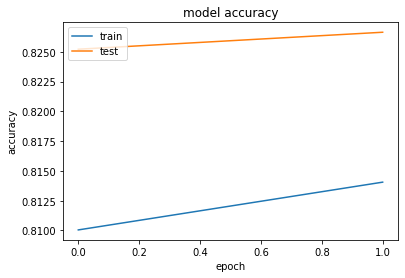

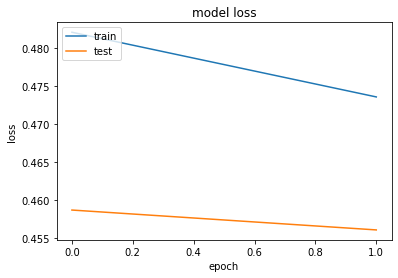

In [55]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Plot the model trained for 200 total epochs loss curves
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs"); # note: epochs will only show 100 since we overrid the history variable